# Import

In [137]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import warnings
import seaborn as sn
from sklearn.model_selection import GridSearchCV
warnings.filterwarnings("ignore")

# Table of content
* [Dataset](#1)
* [Data pre-processing](#2)
* [Class distribution](#3)
* [Train and test split](#4)
* [Random Forest Classification](#5)
* [Confusion  Matrix](#6)
* [XGBOOST](#7)
* [Grid Search](#8)
* [Class Balancing](#9)
    * [RFC](#9.1)
    * [XGBOOST](#9.2)

# Dataset : <a id="1"></a>

This time, the [dataset](https://www.kaggle.com/kingburrito666/basic-computer-data-set) is not custom, it comes from Kaggle.com, a very well known site for finding datasets in the Machine and Deeplearning community, we will have to use other datasets from this platform during our projects.

In [33]:
df = pd.read_csv("Dataset/Computers.csv")

In [35]:
df.head()

,Unnamed: 0,price,speed,hd,ram,screen,cd,multi,premium,ads,trend
0,1,1499,25,80,4,14,no,no,yes,94,1
1,2,1795,33,85,2,14,no,no,yes,94,1
2,3,1595,25,170,4,15,no,no,yes,94,1
3,4,1849,25,170,8,14,no,no,no,94,1
4,5,3295,33,340,16,14,no,no,yes,94,1


Our dataset here consists of 11 columns, it is a dataset around our previous topic, the company that sells computers.
Here we can see computer characteristics, price, fan speeds, hard drive capacity, number of gigs of Ram, screen size, whether the computer has a CD drive, whether it has a multi-power supply, whether it has a premium OS etc...
The shop manager asked us to classify the PCs sold by the company into 3 categories, entry-level, mid-range and high-end.

# Data pre-processing : <a id="2"></a>

In [36]:
df.columns

Index(['Unnamed: 0', 'price', 'speed', 'hd', 'ram', 'screen', 'cd', 'multi',
       'premium', 'ads', 'trend'],
      dtype='object')

In [37]:
df.columns = ['ID', 'categorie', 'speed', 'hd', 'ram', 'screen', 'cd', 'multi',
       'premium', 'ads', 'trend']

In the columns, 'cd', 'multi' and 'premium', the variables take 2 distinct textual values 'yes' and 'no', in general when we want to work on data, we must avoid textual variables as much as possible (except in the case of text analysis with NLP we will come back to this in a future topic). We have therefore done some data prepocessing on our data, in fact we have done a special case of [one-hot-encoding](https://fr.wikipedia.org/wiki/Encodage_one-hot) in order to change our 'yes' and 'no' fields into 1 and 0, to facilitate the work of our model

In [38]:
np.unique(df['cd'])

array(['no', 'yes'], dtype=object)

In [39]:
housing_map = {'yes': 1, 'no': 0}
df['cd'] = df['cd'].map(housing_map)

In [40]:
np.unique(df['multi'])

array(['no', 'yes'], dtype=object)

In [41]:
housing_map = {'yes': 1, 'no': 0}
df['multi'] = df['multi'].map(housing_map)

In [42]:
np.unique(df['premium'])

array(['no', 'yes'], dtype=object)

In [43]:
housing_map = {'yes': 1, 'no': 0}
df['premium'] = df['premium'].map(housing_map)

In [44]:
df.head()

,ID,categorie,speed,hd,ram,screen,cd,multi,premium,ads,trend
0,1,1499,25,80,4,14,0,0,1,94,1
1,2,1795,33,85,2,14,0,0,1,94,1
2,3,1595,25,170,4,15,0,0,1,94,1
3,4,1849,25,170,8,14,0,0,0,94,1
4,5,3295,33,340,16,14,0,0,1,94,1


We now have a much cleaner dataset with only numerical data.

In [45]:
df = df.drop('ID', axis=1)

This exercise will be an exercise in classification, here we will classify our product in three categories according to cost, category 0, corresponds to the entry level of the product (-1400 €), category 1, which corresponds to the middle of the range (between 1400 and 2000 €) and finally category 2, the top of the range (+2000 €)

In [46]:
for i in range (0,len(df)):
    if df['categorie'][i]<1400:
        df['categorie'].loc[i]=0
    elif 1400 <= df['categorie'][i] <= 2000:
        df['categorie'].loc[i]=1
    else:
        df['categorie'].loc[i]=2

In [47]:
df.head()

,categorie,speed,hd,ram,screen,cd,multi,premium,ads,trend
0,1,25,80,4,14,0,0,1,94,1
1,1,33,85,2,14,0,0,1,94,1
2,1,25,170,4,15,0,0,1,94,1
3,1,25,170,8,14,0,0,0,94,1
4,2,33,340,16,14,0,0,1,94,1


# Class distribution : <a id="3"></a>

On this graph, we see the distribution of the number of products per class, we see that the classes are totally unbalanced, class 2 is over-represented compared to class 0 **(we will show after that it is not a problem)**. In spite of this imbalance which will happen in many of your datasets, we will see if our models can generalize and classify our computers in the right categories (low end, mid range or high end)

Text(0, 0.5, 'Categorie')

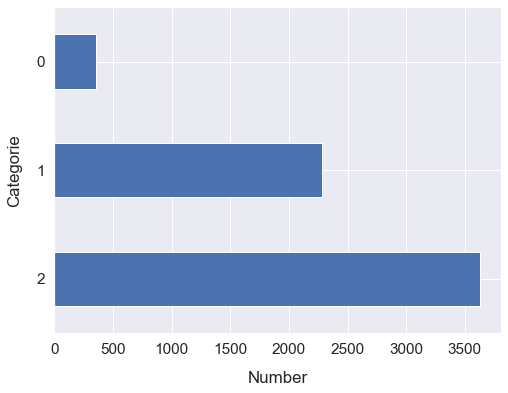

In [48]:
plt.figure();
df['categorie'].value_counts().plot(kind='barh', figsize=(8, 6))
plt.xlabel("Number", labelpad=14)
plt.ylabel("Categorie", labelpad=14)

# Train and test split : <a id="4"></a>

Comme pour la tâche de prédiction, lors d'une tâche de classification nous devons constituer un dataset d'entrainement et un dataset de validation. 

In [49]:
X = df.drop('categorie', axis=1)

In [50]:
Y=df['categorie']

In [51]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.5)

# Random Forest Classification : <a id="5"></a>

To classify our data we will first use a very classical model in machine learning and especially in classification, the [Random Forest](https://fr.wikipedia.org/wiki/For%C3%AAt_d%27arbres_d%C3%A9cisionnels), which as its name indicates is based on decision trees. To evaluate the efficiency of the model, we will use a metric that we did not use in forecasting, the [accuracy](https://developers.google.com/machine-learning/crash-course/classification/accuracy)

In [35]:
rfc = RandomForestClassifier(random_state=1, n_estimators=1000, max_depth= 20)
rfc.fit(X_train, Y_train)
y_pred = rfc.predict(X_test)
print('Model accuracy score : {0:0.4f}'. format(accuracy_score(Y_test, y_pred)))

Model accuracy score : 0.8578


# Confusion  Matrix : <a id="6"></a>

The Confusion Matrix is a matrix that shows how our model has classified the classes. If you don't know how this matrix works please refer to this [article](https://towardsdatascience.com/reading-a-confusion-matrix-60c4dd232dd4) 

In [53]:
confusion_matrix(Y_test, y_pred)

array([[  70,   81,    0],
       [  45,  957,  156],
       [   0,  150, 1671]], dtype=int64)

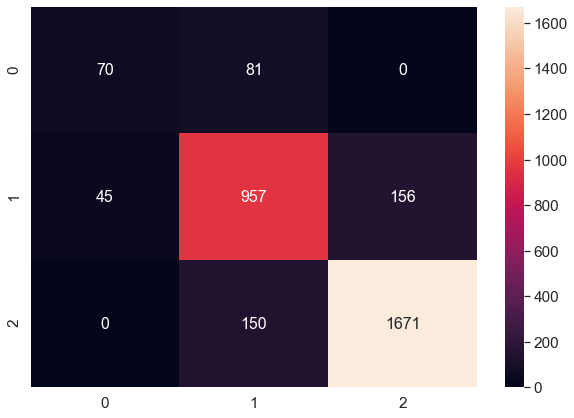

In [54]:
df_cm = pd.DataFrame(confusion_matrix(Y_test, y_pred), range(3), range(3))
plt.figure(figsize=(10,7))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g')
plt.show()

We can see that despite the fact that the classification is not exact, our model does not confuse opposing classes, in fact thanks to the matrix we can see that no entry-level product has been classified as high-end and vice versa, so this means that our model has a certain understanding of the environment and understands the characteristics between the opposing classes, it still has a bit of trouble with the mid-range class, which is more abstract than the other two classes.

# XGBOOST : <a id="7"></a>

XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It implements machine learning algorithms under the Gradient Boosting framework. XGBoost provides a parallel tree boosting (also known as GBDT, GBM) that solve many data science problems in a fast and accurate way. 
Here we bring out the heavy artillery!

In [135]:
model = XGBClassifier(eval_metric='mlogloss',
                      learning_rate =0.1, 
                      n_estimators=1000, 
                      max_depth=1, 
                      use_label_encoder=False, 
                      min_child_weight=1)

In [121]:
print(model)

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              eval_metric='mlogloss', gamma=None, gpu_id=None,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=1,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=None, num_parallel_tree=None,
              objective='binary:logistic', random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, use_label_encoder=False,
              validate_parameters=None, verbosity=None)


In [136]:
model.fit(X_train,Y_train)
y_pred = model.predict(X_test)
print('Model accuracy score : {0:0.4f}'. format(accuracy_score(Y_test, y_pred)))

Model accuracy score : 0.8324


In [58]:
confusion_matrix(Y_test, y_pred)

array([[  79,   72,    0],
       [  43,  989,  126],
       [   0,  132, 1689]], dtype=int64)

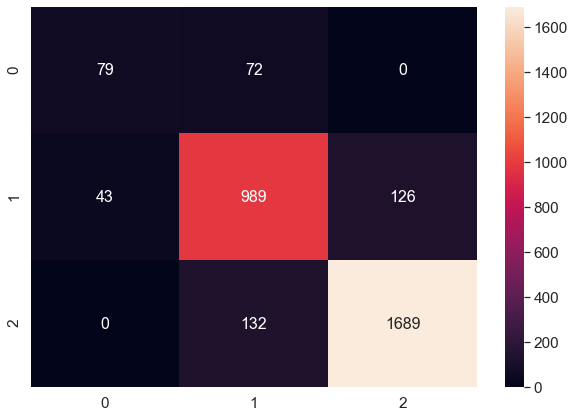

In [59]:
df_cm = pd.DataFrame(confusion_matrix(Y_test, y_pred), range(3), range(3))
plt.figure(figsize=(10,7))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g')
plt.show()

# Grid Search : <a id="8"></a>

We notice that the XGBOOST model is composed of a lot of hyperparameters, the question is how can we be sure to have the right ones? Well, we are going to perform what we call a grid search, the goal is to test all the combinations of hyperparameters to find the most optimal ones, a bit like testing all the combinations of a code box to open it. This process can be very long for some models (from several hours to several months for some models with billions of hyperparameters like the [GPT3](https://fr.wikipedia.org/wiki/GPT-3))

![image.png](img/lock.gif)

In [61]:
param_test1 = {
 'max_depth':range(3,25,1),
 'min_child_weight':range(1,11,1)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=1000, eval_metric='mlogloss'), 
param_grid = param_test1,n_jobs=4,iid=False, cv=5)
gsearch1.fit(X_train, Y_train)
print('The parameters combination that would give best accuracy is : ')
print(gsearch1.best_params_)
print('The best accuracy achieved after parameter tuning via grid search is : ', gsearch1.best_score_)

The parameters combination that would give best accuracy is : 
{'max_depth': 3, 'min_child_weight': 2}
The best accuracy achieved after parameter tuning via grid search is :  0.8584214696485624


# Class Balancing : <a id="9"></a>

We see that despite a powerful model and optimal hyperparameters, our accuracy does not increase enormously, perhaps the solution is elsewhere, for example in the balancing of our classes.
Indeed we had seen previously that our classes were not balanced, to remedy this, there are 2 solutions, 
The undersampling which consists in rebalancing the dataset by decreasing the number of instance of the majority class and the oversampling which has the opposite consists in artificially increasing the number of instance of the minority class.

![image.png](img/undersampling_oversampling.png)

Here we will use undersampling on our classes 1 and 2 

In [109]:
count_class_0 = df[df['categorie']==0].count()['categorie']
df_class_0 = df[df['categorie'] == 0]
df_class_1 = df[df['categorie'] == 1]
df_class_2 = df[df['categorie'] == 2]

In [115]:
df_class_2_under = df_class_2.sample(count_class_0)
df_class_1_under = df_class_1.sample(count_class_0)
df_test_under = pd.concat([df_class_2_under, df_class_1_under, df_class_0], axis=0)

Text(0, 0.5, 'Categorie')

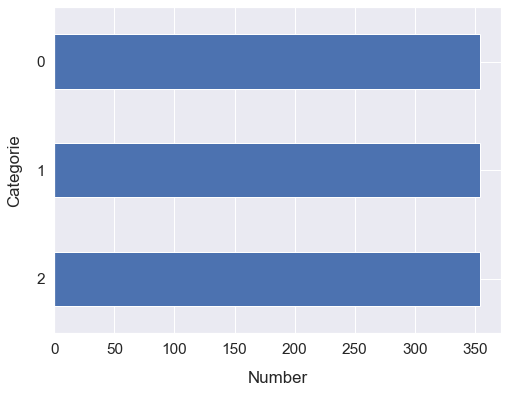

In [114]:
plt.figure();
df_test_under['categorie'].value_counts().plot(kind='barh', figsize=(8, 6))
plt.xlabel("Number", labelpad=14)
plt.ylabel("Categorie", labelpad=14)

In [123]:
X = df_test_under.drop('categorie', axis=1)
Y=df_test_under['categorie']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.5)

### Random Forest <a id="9.1"></a>

In [34]:
rfc = RandomForestClassifier(random_state=1, n_estimators=100, max_depth= 20)
rfc.fit(X_train, Y_train)
y_pred = rfc.predict(X_test)
print('Model accuracy score : {0:0.4f}'. format(accuracy_score(Y_test, y_pred)))

Model accuracy score : 0.8559


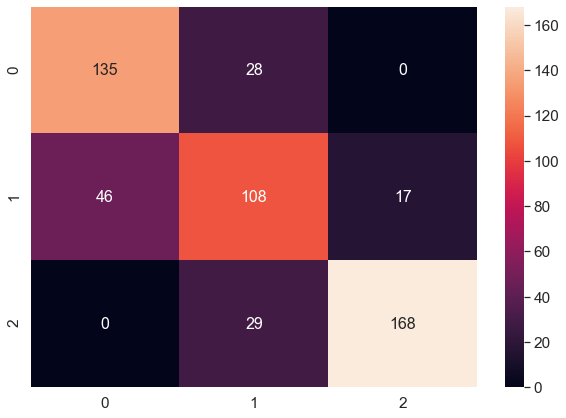

In [133]:
df_cm = pd.DataFrame(confusion_matrix(Y_test, y_pred), range(3), range(3))
plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) 
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g')
plt.show()

### XGBOOST  <a id="9.2"></a>

In [128]:
model.fit(X_train,Y_train)
y_pred = model.predict(X_test)
print('Model accuracy score : {0:0.4f}'. format(accuracy_score(Y_test, y_pred)))

Model accuracy score : 0.8324


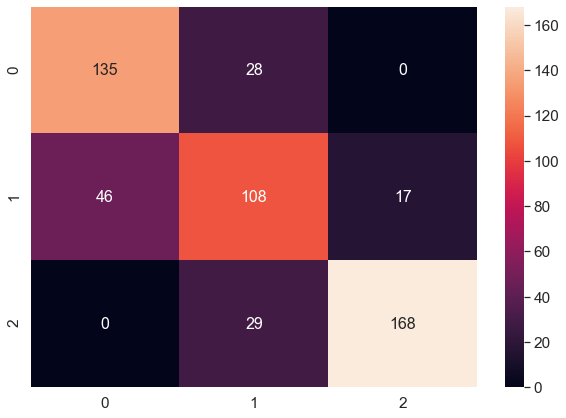

In [134]:
df_cm = pd.DataFrame(confusion_matrix(Y_test, y_pred), range(3), range(3))
plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) 
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g') 
plt.show()

Note that here, balancing class 0 finally results in an equavalent score than with an unbalanced data set.
 **Unbalanced classes are not a problem, and oversampling will not solve a non-problem !**